In [33]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import mpld3
from mpld3 import plugins
import os
from datetime import datetime,date,timedelta,time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from sqlalchemy import create_engine, types, text

In [7]:
def get_fear_greed_data(limit=30):
    url = f"https://api.alternative.me/fng/?limit={limit}&format=json&date_format=us"
    response = requests.get(url)
    data = response.json()["data"]
    # Convert the data into a DataFrame
    fear_greed_df = pd.DataFrame(data)
    fear_greed_df['date'] = pd.to_datetime(fear_greed_df['timestamp']).dt.date
    fear_greed_df['value'] = fear_greed_df['value'].astype(int)
    return fear_greed_df[['date','value_classification' ,'value']]

In [222]:

# Replace with your actual CoinAPI key
#api_key = os.environ.get("COINAPI_KEY")
api_key = '44321bcd-b97e-4fdd-8098-f114eed3fba7'

def get_real_time_price(symbol, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD"
    headers = {
        "X-CoinAPI-Key": api_key
    }
    response = requests.get(url, headers=headers)
    data = response.json()
    
    if 'rate' in data:
        return data['rate']
    else:
        print(f"Error fetching real-time price: {data}")
        return None

def get_historical_price_data(symbol, start_date, end_date, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD/history"
    
    headers = {
        "X-CoinAPI-Key": api_key
    }
    
    params = {
        "period_id": "30MIN", # get data every 30 minutes
        "time_start": start_date.isoformat(),
        "time_end": end_date.isoformat(),
        "limit": 100000
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    
    if not isinstance(data, list) or len(data) == 0:
        print(f"Unexpected API response: {data}")
        return pd.DataFrame(columns=['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price'])
    
    df = pd.DataFrame(data)

    return df

def transform_price_data(df):
    # print(df.head())
    df['date'] = pd.to_datetime(df['time_period_start']).dt.date
    df = df.rename(columns={'rate_open':'daily_open_price','rate_close':'daily_close_price','rate_low': 'daily_min_price', 'rate_high': 'daily_max_price'})
    df = df[['date', 'daily_open_price','daily_close_price','daily_min_price', 'daily_max_price']]
    print(df.head())
    df['daily_avg_price'] = (df['daily_min_price'] + df['daily_max_price']) / 2
    df['daily_change'] = (df['daily_close_price'] - df['daily_open_price']) / df['daily_open_price']
    print(df.head())

    # Calculate weekly change
    df['weekly_change'] = df['daily_close_price'].pct_change(periods=7)
    # Calculate the change between Monday and Friday in the current week
    df['weekday'] = pd.to_datetime(df['date']).dt.weekday
    df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week
    df['year'] = pd.to_datetime(df['date']).dt.year

    # Group by year and week
    weekly_groups = df.groupby(['year', 'week'])

    # Initialize a list to store the weekly changes
    weekly_changes = []

    for (year, week), group in weekly_groups:
        monday_price = group[group['weekday'] == 0]['daily_close_price']
        friday_price = group[group['weekday'] == 4]['daily_close_price']
        
        if not monday_price.empty and not friday_price.empty:
            weekly_change = (friday_price.values[0] - monday_price.values[0]) / monday_price.values[0]
            weekly_changes.append({'year': year, 'week': week, 'weekly_change': weekly_change})

    # Convert the list to a DataFrame
    weekly_change_df = pd.DataFrame(weekly_changes)

    # Merge the weekly changes back to the original DataFrame
    df = df.merge(weekly_change_df, on=['year', 'week'], how='left')

    rt_price = get_real_time_price(symbol, api_key)
    rt_df = pd.DataFrame({
    'date': [pd.to_datetime('now').date()],  # Use current date
    'daily_open_price': [rt_price],    # Assuming open and close are the same for real-time
    'daily_close_price': [rt_price],
    'daily_change': [0],
    'daily_avg_price': [rt_price],    # Use the real-time price
    'daily_min_price': [rt_price],     # Assuming min and max are the same for real-time
    'daily_max_price': [rt_price]
    })

    # print(rt_df.head())

    # Join the real-time price DataFrame with historical
    df = pd.concat([df, rt_df], ignore_index=True)

    # Optionally, sort the DataFrame by date
    df.sort_values('date', ascending=True, inplace=True)

    # generate utility columns

    # Initialize current max price
    current_max_price = 0
    # List to store the price ratios
    price_ratios = []
    max_prices = []

    # Calculate price ratios
    for index, row in df.iterrows():
        daily_avg_price = row['daily_avg_price']
        
        # Update current max price
        current_max_price = max(current_max_price, daily_avg_price)      
        # Calculate the ratio
        price_ratio = (daily_avg_price - current_max_price) / current_max_price
        price_ratios.append(price_ratio)
        max_prices.append(current_max_price)
    # Add the price ratios to the DataFrame

    df['price_ratio'] = price_ratios
    df['current_max_price'] = max_prices  # Add current max price as a new column

 
    
    df['MA_30'] = df['daily_avg_price'].rolling(window=30).mean()
    df['MA_60'] = df['daily_avg_price'].rolling(window=60).mean()
    df['MA_90'] = df['daily_avg_price'].rolling(window=90).mean()
    df['MA_120'] = df['daily_avg_price'].rolling(window=120).mean()
    df['MA_150'] = df['daily_avg_price'].rolling(window=150).mean()
    df['MA_180'] = df['daily_avg_price'].rolling(window=180).mean()
    # df['MA125_ratio'] = (df['MA_125']- df['daily_avg_price']) / df['daily_avg_price']
    df['MA30_ratio'] = (df['MA_30']- df['daily_avg_price']) / df['daily_avg_price']
    df['MA60_ratio'] = (df['MA_60'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA90_ratio'] = (df['MA_90'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA120_ratio'] = (df['MA_120'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA150_ratio'] = (df['MA_150'] - df['daily_avg_price']) / df['daily_avg_price']
    df['MA180_ratio'] = (df['MA_180'] - df['daily_avg_price']) / df['daily_avg_price']
    return df[['date','daily_open_price','daily_close_price','daily_change', 'daily_min_price', 'daily_max_price', 'daily_avg_price','current_max_price','price_ratio','MA_30','MA_60','MA_90','MA_120','MA_150','MA_180', \
    'MA30_ratio', 'MA60_ratio','MA90_ratio','MA120_ratio','MA150_ratio','MA180_ratio']]


def get_price_data(symbol,start_date):
    end_date = date.today()
    return get_historical_price_data(symbol, start_date, end_date, api_key)

In [14]:

def transform_price_data_daily(df):
    """
    Transform 30-minute Bitcoin price data into daily statistics aligned with US market hours.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with 30-min Bitcoin price data in UTC
    
    Returns:
    pd.DataFrame: Daily statistics including market open/close prices and daily averages
    """
    # Convert timestamps to datetime if they aren't already
    df['time_open'] = pd.to_datetime(df['time_open'])
    df['time_close'] = pd.to_datetime(df['time_close'])
    
    # Check if timestamps are already timezone aware
    is_tz_aware = df['time_open'].dt.tz is not None
    
    # Convert timestamps to US Eastern time
    if is_tz_aware:
        # If already tz-aware, just convert
        df['time_open_et'] = df['time_open'].dt.tz_convert('US/Eastern')
        df['time_close_et'] = df['time_close'].dt.tz_convert('US/Eastern')
    else:
        # If not tz-aware, localize first
        df['time_open_et'] = df['time_open'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
        df['time_close_et'] = df['time_close'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    
    # Add date column for grouping
    df['date'] = df['time_open_et'].dt.date
    
    # Create daily summary DataFrame
    daily_data = []
    
    for date, group in df.groupby('date'):
        # Convert date to datetime for proper comparison
        date_dt = pd.to_datetime(date)
        
        # Define market hours for this date
        market_open = pd.Timestamp.combine(date_dt.date(), time(9, 30)).tz_localize('US/Eastern')
        market_close = pd.Timestamp.combine(date_dt.date(), time(16, 0)).tz_localize('US/Eastern')
        
        # Find closest data points to market open and close
        open_price_row = group[
            (group['time_open_et'] <= market_open) & 
            (group['time_close_et'] >= market_open)
        ]
        
        close_price_row = group[
            (group['time_open_et'] <= market_close) & 
            (group['time_close_et'] >= market_close)
        ]
        
        # Handle edge cases where rows might be empty
        market_open_price = None
        market_close_price = None
        market_open_timestamp = None
        market_close_timestamp = None
        
        if not open_price_row.empty:
            market_open_price = open_price_row['rate_open'].iloc[0]
            market_open_timestamp = market_open
        else:
            # Find closest point before market open
            before_open = group[group['time_open_et'] <= market_open]
            if not before_open.empty:
                market_open_price = before_open.iloc[-1]['rate_close']
                market_open_timestamp = before_open.iloc[-1]['time_close_et']
        
        if not close_price_row.empty:
            market_close_price = close_price_row['rate_close'].iloc[0]
            market_close_timestamp = market_close
        else:
            # Find closest point after market close
            after_close = group[group['time_close_et'] >= market_close]
            if not after_close.empty:
                market_close_price = after_close.iloc[0]['rate_open']
                market_close_timestamp = after_close.iloc[0]['time_open_et']
        
        daily_stats = {
            'date': date,
            'market_open_price': market_open_price,
            'market_open_timestamp': market_open_timestamp,
            'market_close_price': market_close_price,
            'market_close_timestamp': market_close_timestamp,
            'avg_price': group['rate_close'].mean(),
            'daily_high': group['rate_high'].max(),
            'daily_low': group['rate_low'].min(),
        }
        
        daily_data.append(daily_stats)
    
    # Create final DataFrame
    if not daily_data:
        return pd.DataFrame()
    
    daily_df = pd.DataFrame(daily_data)
    
    # Calculate daily price change
    daily_df['daily_price_change'] = (
        (daily_df['daily_high'] - daily_df['daily_low']) / 
        daily_df['daily_low']
    ).round(2)

    # Calculate daily market price change 
    daily_df['market_price_change'] = (
        (daily_df['market_close_price'] - daily_df['market_open_price']) / 
        daily_df['market_open_price']
    ).round(2)
    # Drop rows where market_open_price is NaN
    daily_df = daily_df.dropna(subset=['market_open_price'])

    # generate the monday to friday change

    # Extract the weekday (0=Monday, 4=Friday)
    daily_df['weekday'] = daily_df['date'].dt.weekday

    # Initialize a new column for the price change between Monday and Friday
    daily_df['monday_price'] = None
    daily_df['friday_price'] = None
    daily_df['monday_to_friday_change'] = None

# Iterate through the DataFrame to calculate the price change
    for i in range(len(daily_df) - 4):
        if daily_df.iloc[i]['weekday'] == 0:  # If it's a Monday
            monday_price = daily_df.iloc[i]['market_open_price']
            friday_price = daily_df.iloc[i+4]['market_close_price']
            price_change = (friday_price - monday_price) / monday_price
            daily_df.at[i, 'monday_price'] = monday_price
            daily_df.at[i, 'friday_price'] = friday_price
            daily_df.at[i+4, 'monday_to_friday_change'] = price_change

    
    return daily_df

In [19]:
bitcoin_df_1 = get_historical_price_data("BTC", pd.to_datetime('2025-04-10'), date.today(), api_key)

# bitcoin_df = bitcoin_df[bitcoin_df['date'] >= '2022-01-01']
# bitcoin_df = bitcoin_df[bitcoin_df['date'] >= '2022-01-01']
# bitcoin_df.sort_values('date',ascending=True).head(20)
# bitcoin_df = bitcoin_df[bitcoin_df['date'] >= pd.to_datetime('2001-01').date()]
# bitcoin_df.sort_values('date',ascending=False).head(20)




In [28]:
bitcoin_df_transformed.head(2)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change
1,2025-04-06,82501.920762,2025-04-06 09:30:00-04:00,79326.988191,2025-04-06 16:00:00-04:00,81057.415655,83500.435484,77092.143274,8.31,-3.85
2,2025-04-07,76813.250326,2025-04-07 09:29:59.700000-04:00,78644.449420,2025-04-07 16:00:00-04:00,78014.509811,81127.987680,74416.741606,9.02,2.38


In [30]:
# bitcoin_df_transformed = transform_price_data_daily(bitcoin_df)
bitcoin_df_transformed.head(4)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change
1,2025-04-06,82501.920762,2025-04-06 09:30:00-04:00,79326.988191,2025-04-06 16:00:00-04:00,81057.415655,83500.435484,77092.143274,8.31,-3.85
2,2025-04-07,76813.250326,2025-04-07 09:29:59.700000-04:00,78644.449420,2025-04-07 16:00:00-04:00,78014.509811,81127.987680,74416.741606,9.02,2.38
3,2025-04-08,80150.470729,2025-04-08 09:30:00-04:00,76599.683702,2025-04-08 16:00:00-04:00,77944.304869,80379.249166,74569.723261,7.79,-4.43
4,2025-04-09,76789.077850,2025-04-09 09:30:00-04:00,82047.676938,2025-04-09 16:00:00-04:00,79486.938194,83569.037346,74953.377315,11.49,6.85


In [42]:
# Create a database connection
# Replace these values with your PostgreSQL credentials

db_params = {
    'host': 'localhost',
    'port': '5432',
    'database': 'noma',  # Replace with your database name
    'user': 'postgres',      # Replace with your username
    'password': 'Love520!'   # Replace with your password
}

def update_bitcoin_prices_daily(df, db_params, table_name='bitcoin_prices_daily'):
    """
    Update the bitcoin prices table with merge logic based on date.
    This function will:
    1. Get the latest date from the database
    2. Insert new records for dates not in the database
    3. Update existing records for dates already in the database
    
    Args:
        df (pd.DataFrame): DataFrame containing the bitcoin price data
        db_params (dict): Database connection parameters
        table_name (str): Name of the table to update
    """
    # Create SQLAlchemy engine
    conn_string = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"
    engine = create_engine(conn_string)
    
    try:
        # Get the latest date from the database

        df['updated_at'] = pd.Timestamp.now()
        latest_date_query = f"""
            SELECT MAX(date) as latest_date 
            FROM {table_name}
        """
        latest_date = pd.read_sql(latest_date_query, engine)
        latest_date = latest_date['latest_date'].iloc[0]
        
        if latest_date is not None:
            # Ensure both dates are in the same format (date)
            latest_date = pd.Timestamp(latest_date).date()
            new_data = df[df['date'] > latest_date]
            existing_data = df[df['date'] <= latest_date]
            
        else:
            # If no data exists, all data is new
            new_data = df
            existing_data = pd.DataFrame()
        
        # Define proper data types for timestamp columns
        dtype = {}
        for col in df.columns:
            if 'timestamp' in col.lower() or 'time' in col.lower() or 'date' in col.lower():
                dtype[col] = types.DateTime()
        
        # Insert new records
        if not new_data.empty:
            new_data.to_sql(
                name=table_name,
                con=engine,
                if_exists='append',
                index=False,
                dtype=dtype
            )
            print(f"Inserted {len(new_data)} new records")
        
        # Update existing records
        if not existing_data.empty:
            # Create a temporary table for the updates
            temp_table_name = f"temp_{table_name}"
            existing_data.to_sql(
                name=temp_table_name,
                con=engine,
                if_exists='replace',
                index=False,
                dtype=dtype
            )
            
            # Perform the update using a SQL merge
            update_query = f"""
                UPDATE {table_name} t
                SET 
                    market_open_price = s.market_open_price,
                    market_open_timestamp = s.market_open_timestamp,
                    market_close_price = s.market_close_price,
                    market_close_timestamp = s.market_close_timestamp,
                    avg_price = s.avg_price,
                    daily_high = s.daily_high,
                    daily_low = s.daily_low,
                    daily_price_change = s.daily_price_change,
                    market_price_change = s.market_price_change,
                    updated_at = s.updated_at
                FROM {temp_table_name} s
                WHERE t.date = s.date
            """
            
            with engine.connect() as conn:
                conn.execute(text(update_query))
                conn.commit()
            
            # Drop the temporary table
            with engine.connect() as conn:
                conn.execute(text(f"DROP TABLE IF EXISTS {temp_table_name}"))
                conn.commit()
            
            print(f"Updated {len(existing_data)} existing records")
        
        print(f"Successfully updated {table_name} table")
        
    except Exception as e:
        print(f"Error updating {table_name}: {str(e)}")
        raise



In [43]:
# Example usage:
# Replace your existing database loading code with:
update_bitcoin_prices_daily(bitcoin_df_transformed, db_params, 'bitcoin_prices_daily_test')

Inserted 2 new records
Updated 3 existing records
Successfully updated bitcoin_prices_daily_test table


In [55]:
def load_data_from_db(table_name, db_params, limit=None, order_by='date', order_direction='desc'):
    """
    Load data from a PostgreSQL database table.
    
    Parameters:
    -----------
    table_name : str
        Name of the table to load data from
    db_params : dict
        Dictionary containing database connection parameters
    limit : int, optional
        Number of rows to limit the query to
    order_by : str, optional
        Column to order results by (default: 'date')
    order_direction : str, optional
        Direction to order results ('asc' or 'desc', default: 'desc')
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the loaded data
    """
    try:
        # Create database connection string
        connection_string = f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"
        
        # Create SQLAlchemy engine
        engine = create_engine(connection_string)
        
        # Build the SQL query
        query = f"SELECT * FROM {table_name}"
        
        # Add ORDER BY clause if specified
        if order_by:
            query += f" ORDER BY {order_by} {order_direction}"
        
        # Add LIMIT clause if specified
        if limit:
            query += f" LIMIT {limit}"
        
        # Execute the query and load into a DataFrame
        df = pd.read_sql(query, engine)
        
        print(f"Successfully loaded {len(df)} rows from {table_name}")
        return df
        
    except Exception as e:
        print(f"Error loading data from {table_name}: {str(e)}")
        raise


In [56]:
bitcoin_df_daily = load_data_from_db('bitcoin_prices_daily', db_params)

Successfully loaded 1928 rows from bitcoin_prices_daily


In [186]:
bitcoin_df_daily.head(2)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at
0,2025-04-10,81696.952495,2025-04-10 09:30:00,79555.613960,2025-04-10 16:00:00,80709.979660,82357.628952,78410.422602,5.03,-2.62,2025-04-11 15:38:56.610082
1,2025-04-09,76789.077850,2025-04-09 09:30:00,82047.676938,2025-04-09 16:00:00,79486.938194,83569.037346,74953.377315,11.49,6.85,2025-04-11 15:38:56.610082


In [50]:
# fear_greed_df = get_fear_greed_data(365*14) 
# Convert date column to date type
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date']).dt.date
fear_greed_df

,date,value_classification,value
0,2025-04-12,Fear,43
1,2025-04-11,Extreme Fear,25
2,2025-04-10,Fear,39
3,2025-04-09,Extreme Fear,18
4,2025-04-08,Extreme Fear,24
...,...,...,...
2619,2018-02-05,Extreme Fear,11
2620,2018-02-04,Extreme Fear,24
2621,2018-02-03,Fear,40
2622,2018-02-02,Extreme Fear,15


In [53]:
def merge_data(fear_greed_df, coin_df):
    # Merge the two DataFrames on the 'timestamp' column
    merged_df = pd.merge(fear_greed_df, coin_df, on='date', how='inner')
    return merged_df

In [187]:
merged_bitcoin_fg_df = merge_data(bitcoin_df_daily, fear_greed_df)
merged_bitcoin_fg_df.sort_values('date',ascending=False).head(30)

# merged_bitcoin_fg_df.drop_duplicates(subset=['market_open_price'], inplace=True)

# Drop market_sentiment_x and market_sentiment_y columns if they exist


,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at,value_classification,value
0,2025-04-10,81696.952495,2025-04-10 09:30:00.000,79555.613960,2025-04-10 16:00:00.000,80709.979660,82357.628952,78410.422602,5.03,-2.62,2025-04-11 15:38:56.610082,Fear,39
1,2025-04-09,76789.077850,2025-04-09 09:30:00.000,82047.676938,2025-04-09 16:00:00.000,79486.938194,83569.037346,74953.377315,11.49,6.85,2025-04-11 15:38:56.610082,Extreme Fear,18
2,2025-04-08,80150.470729,2025-04-08 09:30:00.000,76599.683702,2025-04-08 16:00:00.000,77944.304869,80379.249166,74569.723261,7.79,-4.43,2025-04-11 15:38:56.610082,Extreme Fear,24
3,2025-04-07,76813.250326,2025-04-07 09:29:59.700,78644.449420,2025-04-07 16:00:00.000,78014.509811,81127.987680,74416.741606,9.02,2.38,2025-04-11 15:38:56.610082,Extreme Fear,23
4,2025-04-06,82501.920762,2025-04-06 09:30:00.000,79326.988191,2025-04-06 16:00:00.000,81057.415655,83500.435484,77092.143274,8.31,-3.85,2025-04-11 15:38:56.610082,Fear,34
5,2025-04-05,82802.030647,2025-04-05 09:30:00.000,83014.201044,2025-04-05 16:00:00.000,83247.314673,83870.844666,82348.467883,1.85,0.26,2025-04-11 18:34:18.313693,Fear,30
6,2025-04-04,82576.489664,2025-04-04 09:29:59.900,83755.057756,2025-04-04 16:00:00.000,83505.263383,84710.364543,81654.351729,3.74,1.43,2025-04-11 18:34:18.313693,Fear,28
7,2025-04-03,81973.101703,2025-04-03 09:30:00.000,81780.769071,2025-04-03 16:00:00.000,82702.666266,83766.984563,81180.828886,3.19,-0.23,2025-04-11 18:34:18.313693,Extreme Fear,25
8,2025-04-02,84624.319387,2025-04-02 09:30:00.000,85696.751369,2025-04-02 16:00:00.000,84805.950214,88477.013394,82162.931558,7.68,1.27,2025-04-11 18:34:18.313693,Fear,44
9,2025-04-01,83663.661359,2025-04-01 09:29:59.900,84965.966196,2025-04-01 16:00:00.000,84409.296513,85547.438370,82525.947158,3.66,1.56,2025-04-11 18:34:18.313693,Fear,34


In [126]:
def plot_data_with_fear_greed_alerts(merged_df, symbol, buy_points=None):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cryptocurrency price trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['daily_avg_price'], 
            name=f"{symbol} Price", 
            line=dict(color='blue'),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Price:</b> $%{y:.2f}<br>' +
                          '<b>Sentiment:</b> %{text}<br>',
            text=merged_df['value']  # Add sentiment to hover text
        ),
        secondary_y=False,
    )

    # Add Fear & Greed Index trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['value'], 
            name="Fear & Greed Index", 
            line=dict(color='black', width=2),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Fear & Greed Index:</b> %{y}<br>',
        ),
        secondary_y=True,
    )

    # Add moving averages
    moving_averages = ['MA_90','MA_120','MA_180']
    colors = ['green','purple','orange']  # Different colors for each MA

    for ma, color in zip(moving_averages, colors):
        if ma in merged_df.columns:
            fig.add_trace(
                go.Scatter(
                    x=merged_df['date'],
                    y=merged_df[ma],
                    name=ma,
                    line=dict(color=color, width=2, dash='dash')
                )
            )

    # Add MA120_ratio
    # fig.add_trace(
    #     go.Scatter(x=merged_df['date'], y=merged_df['MA120_ratio'], name="MA120_ratio", line=dict(color='yellow', width=2, dash='dash')),
    #     secondary_y=False,
    # )

    # Add colored background for different index ranges
    # fig.add_hrect(y0=0, y1=25, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=25, y1=45, line_width=0, fillcolor="orange", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=45, y1=55, line_width=0, fillcolor="yellow", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=55, y1=75, line_width=0, fillcolor="lightgreen", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=75, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add alert zones
    fig.add_hrect(y0=0, y1=20, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=80, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add annotations for alert zones
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=10, text="Extreme Fear Zone", showarrow=False, font=dict(color="green"), yref="y2")
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=90, text="Extreme Greed Zone", showarrow=False, font=dict(color="red"), yref="y2")

    # Update layout
    fig.update_layout(
        title_text=f"Crypto Fear & Greed Index vs {symbol} Price with Alert Zones",
        xaxis_title="Date",
        yaxis_title=f"{symbol} Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_open_price'].min() * 0.8, merged_df['daily_max_price'].max()], secondary_y=False)
    fig.update_yaxes(range=[0, 100], tickvals=[0, 20, 40, 60, 80, 100],
                     ticktext=['0<br>Extreme<br>Fear', '20', '40', '60', '80', '100<br>Extreme<br>Greed'],
                     secondary_y=True)

    if buy_points is not None and not buy_points.empty:
        fig.add_trace(
            go.Scatter(
                x=buy_points['date'],
                y=buy_points['daily_avg_price'],
                mode='markers',
                name='Buy Points',
                marker=dict(color='green', size=10, symbol='triangle-up'),
                hovertemplate='<b>Buy Date:</b> %{x|%Y-%m-%d}<br>' +
                                '<b>Price:</b> $%{y:.2f}<br>'
            )
        )

    return fig

In [91]:
def plot_data_with_fear_greed_alerts_without_ma(merged_df, symbol, buy_points=None):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cryptocurrency price trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['daily_avg_price'], 
            name=f"{symbol} Price", 
            line=dict(color='blue'),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Price:</b> $%{y:.2f}<br>' +
                          '<b>Sentiment:</b> %{text}<br>',
            text=merged_df['value']  # Add sentiment to hover text
        ),
        secondary_y=False,
    )

    # Add Fear & Greed Index trace
    fig.add_trace(
        go.Scatter(
            x=merged_df['date'], 
            y=merged_df['value'], 
            name="Fear & Greed Index", 
            line=dict(color='black', width=2),
            hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +  # Format date in hover
                          '<b>Fear & Greed Index:</b> %{y}<br>',
        ),
        secondary_y=True,
    )

    # Add moving averages
    # moving_averages = ['MA_90','MA_120','MA_180']
    # colors = ['green','purple','orange']  # Different colors for each MA

    # for ma, color in zip(moving_averages, colors):
    #     if ma in merged_df.columns:
    #         fig.add_trace(
    #             go.Scatter(
    #                 x=merged_df['date'],
    #                 y=merged_df[ma],
    #                 name=ma,
    #                 line=dict(color=color, width=2, dash='dash')
    #             )
    #         )

    # Add MA120_ratio
    # fig.add_trace(
    #     go.Scatter(x=merged_df['date'], y=merged_df['MA120_ratio'], name="MA120_ratio", line=dict(color='yellow', width=2, dash='dash')),
    #     secondary_y=False,
    # )

    # Add colored background for different index ranges
    # fig.add_hrect(y0=0, y1=25, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=25, y1=45, line_width=0, fillcolor="orange", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=45, y1=55, line_width=0, fillcolor="yellow", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=55, y1=75, line_width=0, fillcolor="lightgreen", opacity=0.2, secondary_y=True)
    # fig.add_hrect(y0=75, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add alert zones
    fig.add_hrect(y0=0, y1=20, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=80, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add annotations for alert zones
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=10, text="Extreme Fear Zone", showarrow=False, font=dict(color="green"), yref="y2")
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=90, text="Extreme Greed Zone", showarrow=False, font=dict(color="red"), yref="y2")

    # Update layout
    fig.update_layout(
        title_text=f"Crypto Fear & Greed Index vs {symbol} Price with Alert Zones",
        xaxis_title="Date",
        yaxis_title=f"{symbol} Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_open_price'].min() * 0.8, merged_df['daily_max_price'].max()], secondary_y=False)
    fig.update_yaxes(range=[0, 100], tickvals=[0, 20, 40, 60, 80, 100],
                     ticktext=['0<br>Extreme<br>Fear', '20', '40', '60', '80', '100<br>Extreme<br>Greed'],
                     secondary_y=True)

    if buy_points is not None and not buy_points.empty:
        fig.add_trace(
            go.Scatter(
                x=buy_points['date'],
                y=buy_points['daily_avg_price'],
                mode='markers',
                name='Buy Points',
                marker=dict(color='green', size=10, symbol='triangle-up'),
                hovertemplate='<b>Buy Date:</b> %{x|%Y-%m-%d}<br>' +
                                '<b>Price:</b> $%{y:.2f}<br>'
            )
        )

    return fig

In [92]:
plot_data_with_fear_greed_alerts_without_ma(merged_bitcoin_fg_df,'BTC')

In [82]:
plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df,'BTC')


In [189]:
market_sentiment_df = pd.DataFrame({
    'year': [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
    'market_sentiment': ['Bear', 'Bull', 'Bull', 'Bull', 'Bear', 'Neutral', 'Bull','current']
})

# Assuming your existing DataFrame has a 'year' column
merged_bitcoin_fg_df['year'] = pd.to_datetime(merged_bitcoin_fg_df['date']).dt.year
merged_bitcoin_fg_df = pd.merge(merged_bitcoin_fg_df, market_sentiment_df, on='year', how='inner')

In [190]:
merged_bitcoin_fg_df[merged_bitcoin_fg_df['year']==2025]

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,updated_at,value_classification,value,year,market_sentiment
0,2025-04-10,81696.952495,2025-04-10 09:30:00.000,79555.613960,2025-04-10 16:00:00.000,80709.979660,82357.628952,78410.422602,5.03,-2.62,2025-04-11 15:38:56.610082,Fear,39,2025,current
1,2025-04-09,76789.077850,2025-04-09 09:30:00.000,82047.676938,2025-04-09 16:00:00.000,79486.938194,83569.037346,74953.377315,11.49,6.85,2025-04-11 15:38:56.610082,Extreme Fear,18,2025,current
2,2025-04-08,80150.470729,2025-04-08 09:30:00.000,76599.683702,2025-04-08 16:00:00.000,77944.304869,80379.249166,74569.723261,7.79,-4.43,2025-04-11 15:38:56.610082,Extreme Fear,24,2025,current
3,2025-04-07,76813.250326,2025-04-07 09:29:59.700,78644.449420,2025-04-07 16:00:00.000,78014.509811,81127.987680,74416.741606,9.02,2.38,2025-04-11 15:38:56.610082,Extreme Fear,23,2025,current
4,2025-04-06,82501.920762,2025-04-06 09:30:00.000,79326.988191,2025-04-06 16:00:00.000,81057.415655,83500.435484,77092.143274,8.31,-3.85,2025-04-11 15:38:56.610082,Fear,34,2025,current
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-01-05,97444.789087,2025-01-05 09:29:59.900,98292.390687,2025-01-05 16:00:00.000,98178.573127,99459.182136,97273.157528,2.25,0.87,2025-04-11 18:34:18.313693,Greed,72,2025,current
96,2025-01-04,97983.874283,2025-01-04 09:30:00.000,98584.786375,2025-01-04 16:00:00.100,98061.494598,98755.257257,97532.787353,1.25,0.61,2025-04-11 18:34:18.313693,Greed,73,2025,current
97,2025-01-03,97008.173751,2025-01-03 09:29:59.800,98302.849704,2025-01-03 16:00:00.100,97454.065539,98973.793170,96035.174290,3.06,1.33,2025-04-11 18:34:18.313693,Greed,74,2025,current
98,2025-01-02,96390.143840,2025-01-02 09:29:59.700,97016.261671,2025-01-02 16:00:00.000,96635.834854,97730.662388,95225.018076,2.63,0.65,2025-04-11 18:34:18.313693,Greed,70,2025,current


In [182]:
df = merged_bitcoin_fg_df


# Convert the 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any NaT values that may have resulted from the conversion
if df['date'].isnull().any():
    print("Warning: Some dates could not be converted and are set to NaT.")

# Extract the year from the date column and create a new column
df['year'] = df['date'].dt.year

# Group by both 'year' and 'value_classification' and count occurrences
yearly_sentiment_counts = df[df.year >=2018].groupby(['year', 'market_sentiment','value_classification']).size().reset_index(name='count')


yearly_sentiment_counts[yearly_sentiment_counts['year']==2024]

,year,market_sentiment,value_classification,count
18,2024,Bull,Extreme Fear,8
19,2024,Bull,Extreme Greed,86
20,2024,Bull,Fear,53
21,2024,Bull,Greed,177
22,2024,Bull,Neutral,41


In [152]:
# merged_bitcoin_fg_df.dtypes
# Convert market_price_change_bucket from category to string
merged_bitcoin_fg_df['market_price_change_bucket'] = merged_bitcoin_fg_df['market_price_change_bucket'].astype(str)
merged_bitcoin_fg_df.dtypes

date                          datetime64[ns]
market_open_price                    float64
market_open_timestamp         datetime64[ns]
market_close_price                   float64
market_close_timestamp        datetime64[ns]
avg_price                            float64
daily_high                           float64
daily_low                            float64
daily_price_change                   float64
market_price_change                  float64
updated_at                    datetime64[ns]
value_classification                  object
value                                  int64
market_price_change_bucket            object
year                                   int32
market_sentiment                      object
dtype: object

In [191]:
df = merged_bitcoin_fg_df


# Convert the 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any NaT values that may have resulted from the conversion
if df['date'].isnull().any():
    print("Warning: Some dates could not be converted and are set to NaT.")

# Extract the year from the date column and create a new column
df['year'] = df['date'].dt.year

# Group by both 'year' and 'value_classification' and count occurrences
yearly_sentiment_counts = df[df.year >=2018].groupby(['year', 'market_sentiment','market_price_change_bucket']).size().reset_index(name='count')

yearly_sentiment_counts[yearly_sentiment_counts['year']==2025]
# Display the result


KeyError: 'market_price_change_bucket'

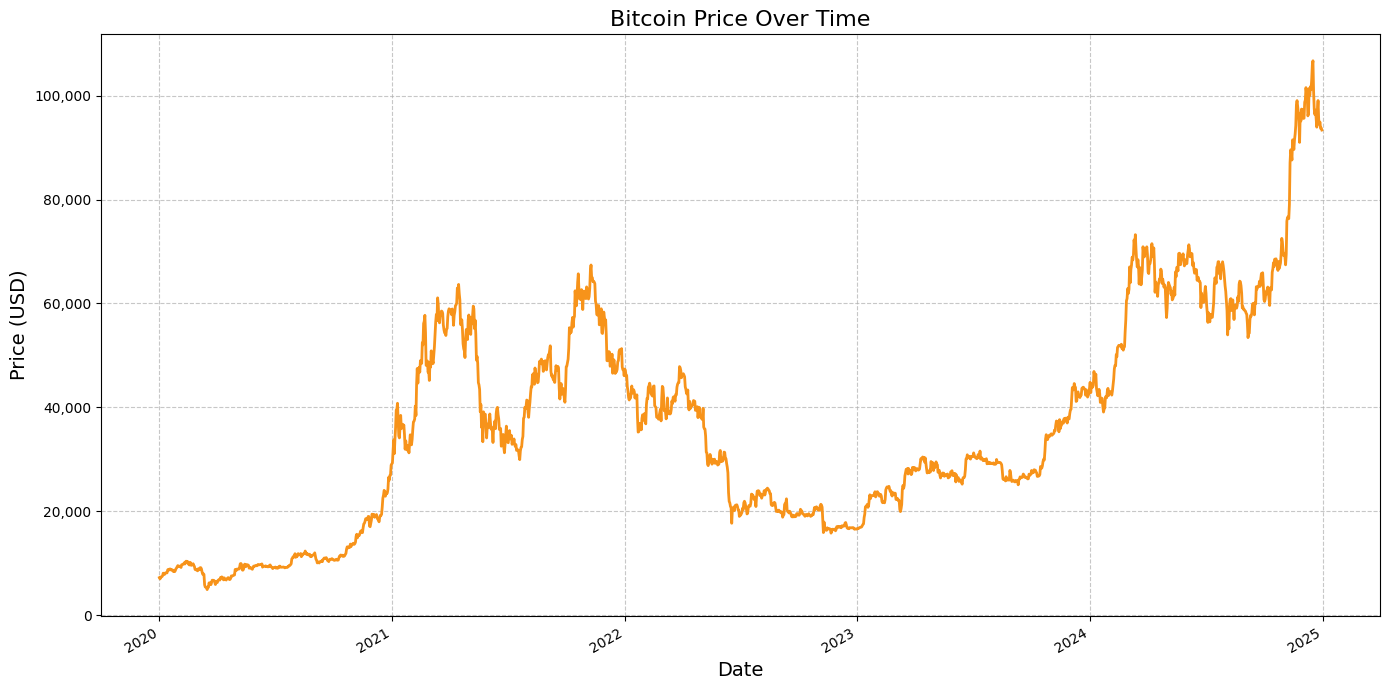

In [166]:
# Create a line chart for date vs BTC price
import matplotlib.pyplot as plt
import pandas as pd

# Make sure the date column is in datetime format
df = merged_bitcoin_fg_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Sort the data by date to ensure proper line plotting
df = df.sort_values('date')

# Create the chart
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['market_close_price'], linewidth=2, color='#F7931A')  # Bitcoin orange color

# Add labels and title
plt.title('Bitcoin Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Format y-axis with commas for thousands
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Improve x-axis date formatting
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


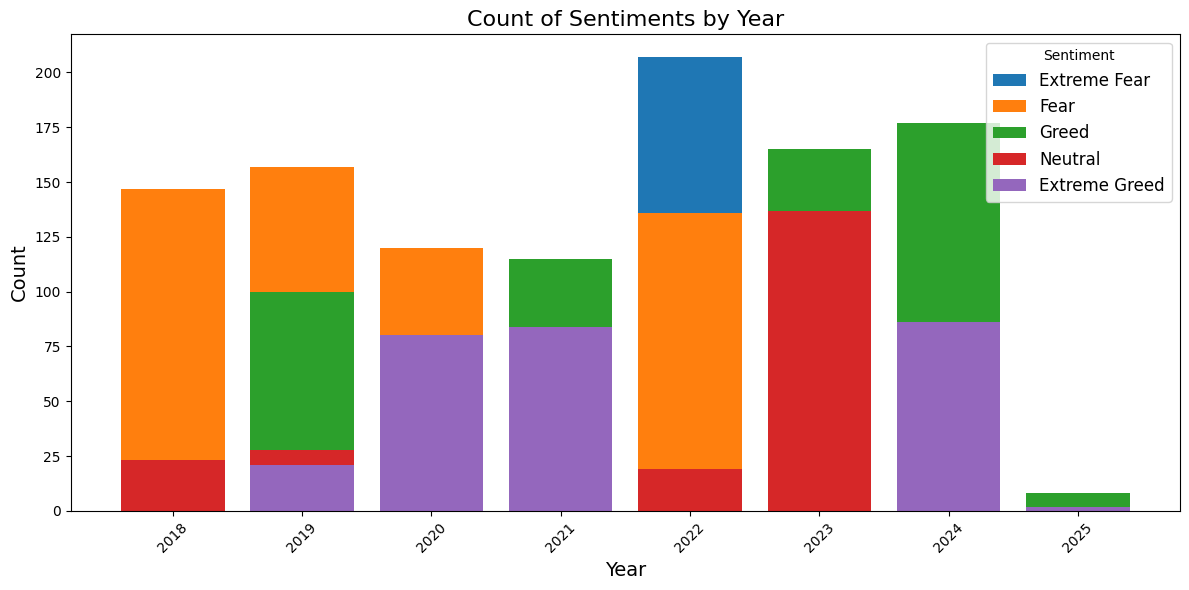

In [97]:
import matplotlib.pyplot as plt

# Sample data for demonstration (replace this with your actual DataFrame)
# yearly_sentiment_counts = pd.DataFrame({
#     'year': [2020, 2020, 2021, 2021],
#     'value_classification': ['Fear', 'Greed', 'Fear', 'Greed'],
#     'count': [10, 15, 20, 25]
# })

# Create a bar plot
plt.figure(figsize=(12, 6))

# Create a bar for each sentiment classification per year
for sentiment in yearly_sentiment_counts['value_classification'].unique():
    subset = yearly_sentiment_counts[yearly_sentiment_counts['value_classification'] == sentiment]
    plt.bar(subset['year'], subset['count'], label=sentiment)

# Add titles and labels
plt.title('Count of Sentiments by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

In [134]:
fig = plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df, "BTC")
fig.show()

In [ ]:
merged_bitcoin_fg_df.head()
merged_bitcoin_fg_df.sort_values('date').iloc[-1]['daily_avg_price']

np.float64(62056.4222048493)

In [219]:
def create_pivot_table_with_buckets_with_year(df, column_names, bins):
    """
    Creates a pivot table grouped by years with specified buckets for given columns.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    column_names (list): List of column names to create buckets for
    bins (list): List of bin edges for bucketing the data
    
    Returns:
    pd.DataFrame: Pivot table with counts and percentages by year and market sentiment
    """
    # Initialize empty DataFrame for pivot table
    pivot_table = pd.DataFrame()

    for column in column_names:
        # Create bucket column
        df[f'{column}_bucket'] = pd.cut(df[column], bins=bins, include_lowest=True)
        df[f'{column}_bucket'] = df[f'{column}_bucket'].astype(str)

        # Group by year, market_sentiment, and bucket
        bucket_counts = df.groupby(['year', 'market_sentiment',f'{column}_bucket']).size().reset_index(name=f'{column}_count')

        # Calculate percentages within each year and market_sentiment group
        yearly_sentiment_totals = bucket_counts.groupby(['year'])[f'{column}_count'].sum()
        bucket_counts[f'{column}_percentage'] = bucket_counts.apply(
            lambda x: (x[f'{column}_count'] / yearly_sentiment_totals[(x['year'])]) * 100, 
            axis=1
        )

        # Merge into pivot table
        if pivot_table.empty:
            pivot_table = bucket_counts
        else:
            pivot_table = pd.merge(
                pivot_table, 
                bucket_counts, 
                on=['year', 'market_sentiment', f'{column}_bucket'], 
                how='inner'
            )

    # Sort by year and market_sentiment
    pivot_table = pivot_table.sort_values(['year'])
    
    num_days = len(df)
    return pivot_table, num_days



# Example call
bins = [-0.5, -0.4,-0.3,-0.2, -0.15, -0.1, -0.05,0, 0.05, 0.1, 0.15, 0.2,0.3,0.4,0.5]  # Define your bin edges
pivot_table, num_days = create_pivot_table_with_buckets_with_year(merged_bitcoin_fg_df, ['market_price_change'], bins)



In [229]:
pivot_table, num_days = create_pivot_table_with_buckets_with_year(merged_bitcoin_fg_df, ['market_price_change'], bins)

In [231]:
# Filter out year 2019 from the pivot table
pivot_table = pivot_table[pivot_table['year'] != 2019]

# Display the filtered pivot table
pivot_table


,year,market_sentiment,market_price_change_bucket,market_price_change_count,market_price_change_percentage
1,2020,Bull,"(-0.05, 0.0]",143,39.071038
2,2020,Bull,"(-0.1, -0.05]",3,0.819672
3,2020,Bull,"(-0.15, -0.1]",1,0.273224
4,2020,Bull,"(0.0, 0.05]",213,58.196721
5,2020,Bull,"(0.05, 0.1]",6,1.639344
6,2021,Bull,"(-0.05, 0.0]",187,51.232877
7,2021,Bull,"(-0.1, -0.05]",8,2.191781
8,2021,Bull,"(-0.15, -0.1]",1,0.273973
9,2021,Bull,"(0.0, 0.05]",159,43.561644
10,2021,Bull,"(0.05, 0.1]",9,2.465753


In [197]:
# generate the monday to friday change

# Convert 'date' column to datetime if not already done
merged_bitcoin_fg_df['date'] = pd.to_datetime(merged_bitcoin_fg_df['date'])

# Extract the weekday (0=Monday, 4=Friday)
merged_bitcoin_fg_df['weekday'] = merged_bitcoin_fg_df['date'].dt.weekday

# Initialize a new column for the price change between Monday and Friday
merged_bitcoin_fg_df['monday_price'] = None
merged_bitcoin_fg_df['friday_price'] = None
merged_bitcoin_fg_df['monday_to_friday_change'] = None

# Iterate through the DataFrame to calculate the price change
for i in range(len(merged_bitcoin_fg_df) - 4):
    if merged_bitcoin_fg_df.iloc[i]['weekday'] == 0:  # If it's a Monday
        monday_price = merged_bitcoin_fg_df.iloc[i]['market_open_price']
        friday_price = merged_bitcoin_fg_df.iloc[i+4]['market_close_price']
        price_change = (friday_price - monday_price) / monday_price
        merged_bitcoin_fg_df.at[i, 'monday_price'] = monday_price
        merged_bitcoin_fg_df.at[i, 'friday_price'] = friday_price
        merged_bitcoin_fg_df.at[i+4, 'monday_to_friday_change'] = price_change

# Drop the 'weekday' column as it's no longer needed
# merged_bitcoin_fg_df.drop(columns=['weekday'], inplace=True)

# Display the updated DataFrame


In [201]:
# Drop rows with None values in 'monday_friday_change' column
# num_of_week = len(merged_bitcoin_fg_df) / 7
filtered_df = merged_bitcoin_fg_df.dropna(subset=['monday_to_friday_change'])

bins = [-0.5, -0.4,-0.3,-0.2, -0.15, -0.1, -0.05,0, 0.05, 0.1, 0.15, 0.2,0.3,0.4,0.5]  # Define your bin edges
weekly_pivot_table, num_of_week = create_pivot_table_with_buckets_with_year(filtered_df, ['monday_to_friday_change'], bins)
print(f"Number of weeks: {num_of_week}")
weekly_pivot_table
# weekly_pivot_table.to_csv('weekly_pivot_table.csv', index=False)

Number of weeks: 275


/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_81682/4245859130.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_bucket'] = pd.cut(df[column], bins=bins, include_lowest=True)
/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_81682/4245859130.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_bucket'] = df[f'{column}_bucket'].astype(str)


,year,market_sentiment,monday_to_friday_change_bucket,monday_to_friday_change_count,monday_to_friday_change_percentage
0,2020,Bull,"(-0.05, 0.0]",27,50.943396
1,2020,Bull,"(-0.1, -0.05]",5,9.433962
2,2020,Bull,"(-0.15, -0.1]",2,3.773585
3,2020,Bull,"(0.0, 0.05]",12,22.641509
4,2020,Bull,"(0.05, 0.1]",4,7.547170
5,2020,Bull,"(0.1, 0.15]",1,1.886792
6,2020,Bull,"(0.15, 0.2]",1,1.886792
7,2020,Bull,"(0.2, 0.3]",1,1.886792
15,2021,Bull,"(0.15, 0.2]",3,5.769231
14,2021,Bull,"(0.1, 0.15]",1,1.923077


In [208]:
filtered_df.head(20)

,date,market_open_price,market_open_timestamp,market_close_price,market_close_timestamp,avg_price,daily_high,daily_low,daily_price_change,market_price_change,...,value_classification,value,year,market_sentiment,market_price_change_bucket,weekday,monday_price,friday_price,monday_to_friday_change,monday_to_friday_change_bucket
7,2025-04-03,81973.101703,2025-04-03 09:30:00.000,81780.769071,2025-04-03 16:00:00.000,82702.666266,83766.984563,81180.828886,3.19,-0.23,...,Extreme Fear,25,2025,current,"(-1.5, 0.0]",3,None,None,0.06467,"(0.05, 0.1]"
14,2025-03-27,86361.007912,2025-03-27 09:30:00.000,87194.105984,2025-03-27 16:00:00.000,87158.469208,87711.598772,85818.976369,2.21,0.96,...,Fear,40,2025,current,"(0.0, 1.5]",3,None,None,0.056408,"(0.05, 0.1]"
21,2025-03-20,85116.249178,2025-03-20 09:30:00.000,84457.443257,2025-03-20 16:00:00.000,84930.827408,86490.177225,83611.903858,3.44,-0.77,...,Neutral,49,2025,current,"(-1.5, 0.0]",3,None,None,-0.032394,"(-0.05, 0.0]"
28,2025-03-13,82877.911745,2025-03-13 09:29:59.900,80601.508086,2025-03-13 16:00:00.000,81920.032874,83812.701126,79910.050443,4.88,-2.75,...,Fear,45,2025,current,"(-3.0, -1.5]",3,None,None,-0.02796,"(-0.05, 0.0]"
35,2025-03-06,89945.702083,2025-03-06 09:30:00.000,89033.586075,2025-03-06 16:00:00.100,89676.892276,92803.708802,84710.893016,9.55,-1.01,...,Extreme Fear,25,2025,current,"(-1.5, 0.0]",3,None,None,0.077239,"(0.05, 0.1]"
42,2025-02-27,86244.263154,2025-02-27 09:29:59.900,83826.200184,2025-02-27 16:00:00.000,84558.658735,86987.413440,79421.422342,9.53,-2.80,...,Extreme Fear,10,2025,current,"(-3.0, -1.5]",3,None,None,-0.100205,"(-0.15, -0.1]"
49,2025-02-20,97812.503323,2025-02-20 09:29:59.900,98506.408889,2025-02-20 16:00:00.100,97742.904082,98752.204470,96788.446482,2.03,0.71,...,Neutral,49,2025,current,"(0.0, 1.5]",3,None,None,0.031652,"(0.0, 0.05]"
56,2025-02-13,95954.009671,2025-02-13 09:29:59.900,96266.260144,2025-02-13 16:00:00.100,96226.263197,97245.234432,95230.944887,2.12,0.33,...,Neutral,50,2025,current,"(0.0, 1.5]",3,None,None,-0.003571,"(-0.05, 0.0]"
63,2025-02-06,98295.552254,2025-02-06 09:30:00.000,96523.040191,2025-02-06 16:00:00.000,97517.094575,99169.103250,95695.267045,3.63,-1.80,...,Neutral,49,2025,current,"(-3.0, -1.5]",3,None,None,-0.012413,"(-0.05, 0.0]"
70,2025-01-30,104893.519037,2025-01-30 09:30:00.000,105023.521789,2025-01-30 16:00:00.000,105091.981425,106443.715536,103938.511921,2.41,0.12,...,Greed,70,2025,current,"(0.0, 1.5]",3,None,None,0.10781,"(0.1, 0.15]"


/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_81682/2016363367.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = count_pivot.applymap(str) + '\n(' + percent_pivot.applymap(lambda x: f'{x:.1f}%') + ')'


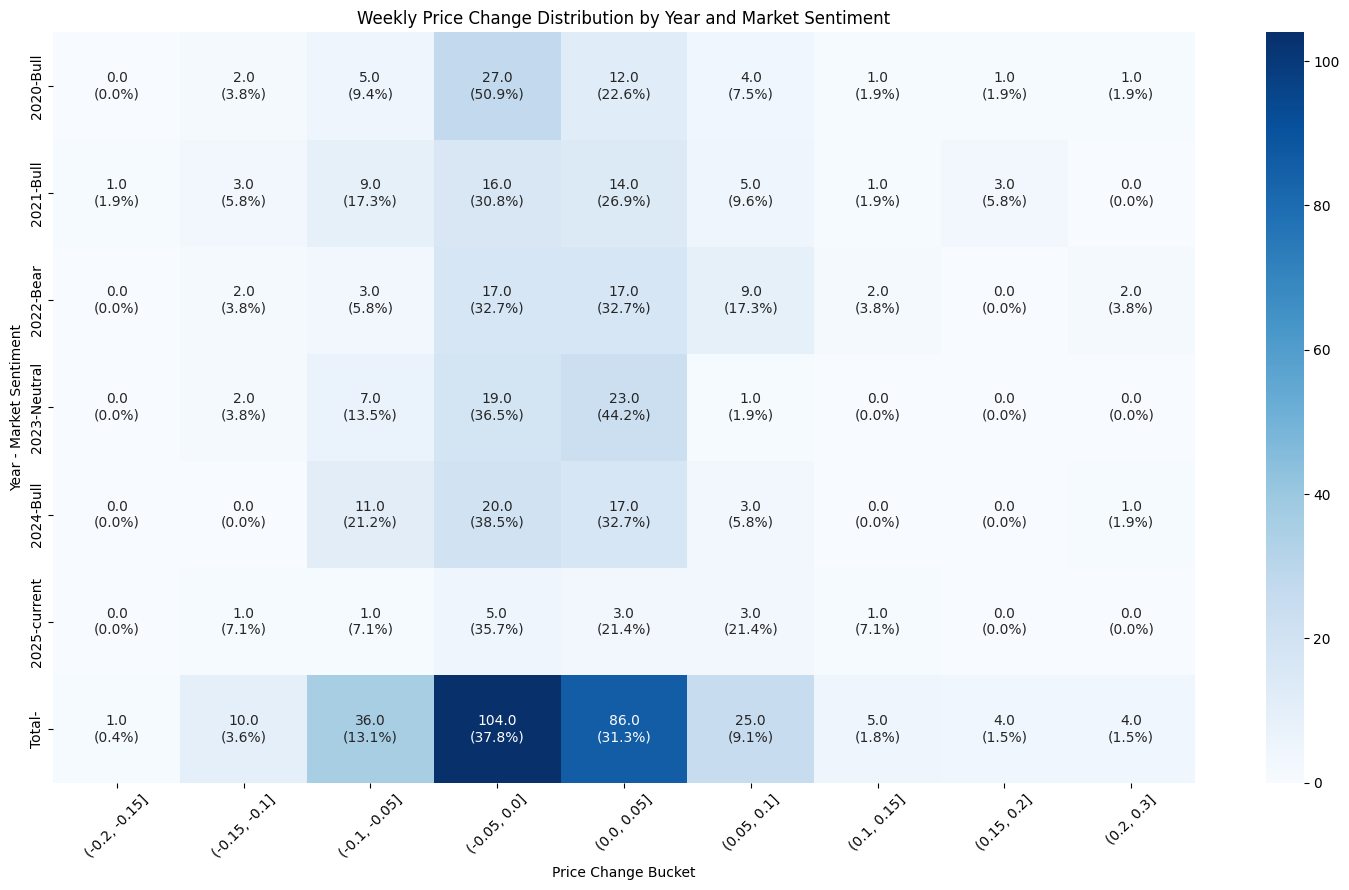

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order of buckets
bucket_order = [
    '(-0.2, -0.15]',
    '(-0.15, -0.1]',
    '(-0.1, -0.05]',
    '(-0.05, 0.0]',
    '(0.0, 0.05]',
    '(0.05, 0.1]',
    '(0.1, 0.15]',
    '(0.15, 0.2]',
    '(0.2, 0.3]'
]

# Create pivot tables for both count and percentage
count_pivot = pd.pivot_table(
    weekly_pivot_table,
    values='monday_to_friday_change_count',
    index=['year', 'market_sentiment'],
    columns='monday_to_friday_change_bucket',
    fill_value=0
)

percent_pivot = pd.pivot_table(
    weekly_pivot_table,
    values='monday_to_friday_change_percentage',
    index=['year', 'market_sentiment'],
    columns='monday_to_friday_change_bucket',
    fill_value=0
)

# Reorder the columns
count_pivot = count_pivot[bucket_order]
percent_pivot = percent_pivot[bucket_order]

# Calculate totals
total_counts = count_pivot.sum()
total_percentages = (total_counts / total_counts.sum() * 100)

# Add totals as a new row with just 'Total' as the label
count_pivot.loc[('Total', ''), :] = total_counts
percent_pivot.loc[('Total', ''), :] = total_percentages

# Create annotation text combining count and percentage
annotations = count_pivot.applymap(str) + '\n(' + percent_pivot.applymap(lambda x: f'{x:.1f}%') + ')'

# Create heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(count_pivot, annot=annotations, fmt='', cmap='Blues')
plt.title('Weekly Price Change Distribution by Year and Market Sentiment')
plt.xlabel('Price Change Bucket')
plt.ylabel('Year - Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [233]:
pivot_table.head(20)

,year,market_sentiment,market_price_change_bucket,market_price_change_count,market_price_change_percentage
1,2020,Bull,"(-0.05, 0.0]",143,39.071038
2,2020,Bull,"(-0.1, -0.05]",3,0.819672
3,2020,Bull,"(-0.15, -0.1]",1,0.273224
4,2020,Bull,"(0.0, 0.05]",213,58.196721
5,2020,Bull,"(0.05, 0.1]",6,1.639344
6,2021,Bull,"(-0.05, 0.0]",187,51.232877
7,2021,Bull,"(-0.1, -0.05]",8,2.191781
8,2021,Bull,"(-0.15, -0.1]",1,0.273973
9,2021,Bull,"(0.0, 0.05]",159,43.561644
10,2021,Bull,"(0.05, 0.1]",9,2.465753


/var/folders/xl/nbd4ft0j4c3120jl664htp4m0000gn/T/ipykernel_81682/37844447.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = count_pivot.applymap(str) + '\n(' + percent_pivot.applymap(lambda x: f'{x:.1f}%') + ')'


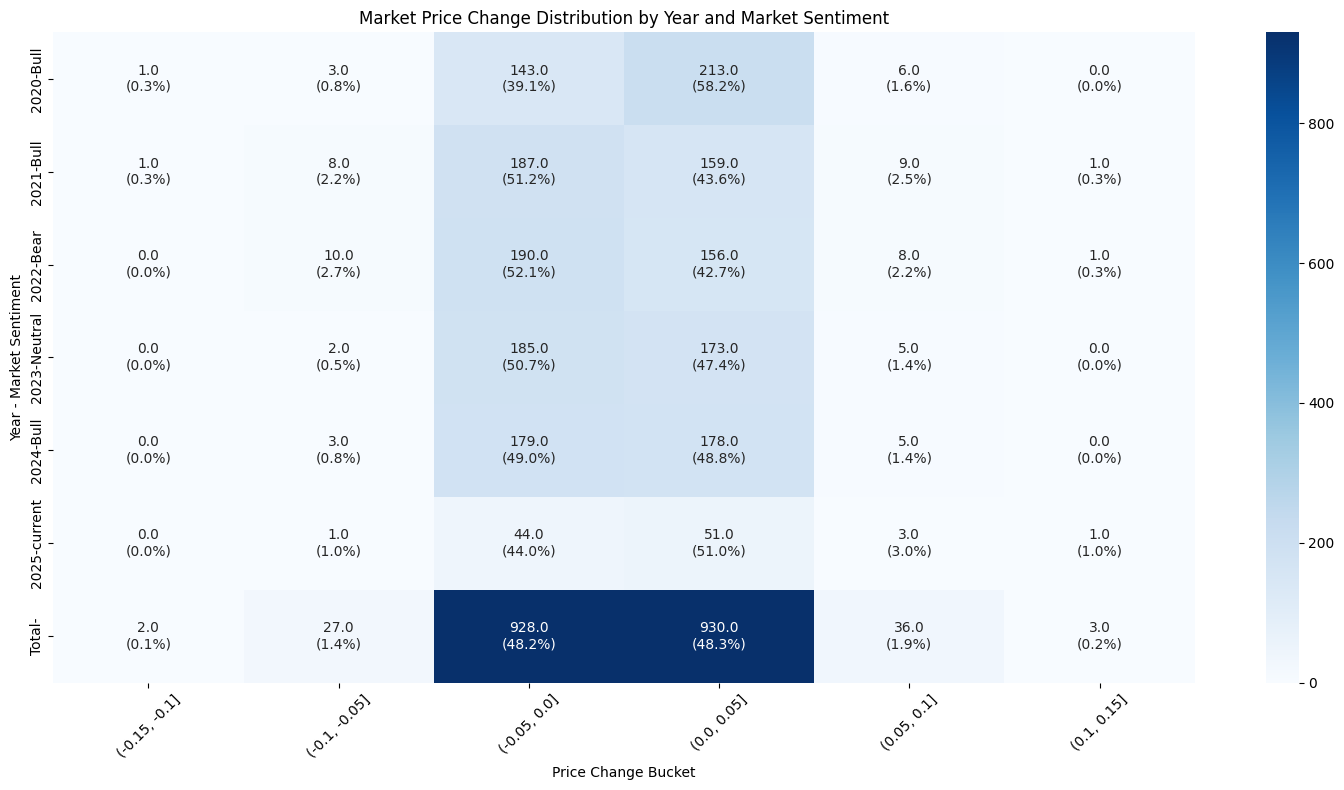

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order of buckets
bucket_order = [

    '(-0.15, -0.1]',
    '(-0.1, -0.05]',
    '(-0.05, 0.0]',
    '(0.0, 0.05]',
    '(0.05, 0.1]',
    '(0.1, 0.15]'
]

# Create pivot tables for both count and percentage
count_pivot = pd.pivot_table(
    pivot_table,
    values='market_price_change_count',
    index=['year', 'market_sentiment'],
    columns='market_price_change_bucket',
    fill_value=0
)

percent_pivot = pd.pivot_table(
    pivot_table,
    values='market_price_change_percentage',
    index=['year', 'market_sentiment'],
    columns='market_price_change_bucket',
    fill_value=0
)

# Reorder the columns
count_pivot = count_pivot[bucket_order]
percent_pivot = percent_pivot[bucket_order]


# Calculate totals
total_counts = count_pivot.sum()
total_percentages = (total_counts / total_counts.sum() * 100)

# Add totals as a new row with just 'Total' as the label
count_pivot.loc[('Total', ''), :] = total_counts
percent_pivot.loc[('Total', ''), :] = total_percentages

# Create annotation text combining count and percentage
annotations = count_pivot.applymap(str) + '\n(' + percent_pivot.applymap(lambda x: f'{x:.1f}%') + ')'

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(count_pivot, annot=annotations, fmt='', cmap='Blues')
plt.title('Market Price Change Distribution by Year and Market Sentiment')
plt.xlabel('Price Change Bucket')
plt.ylabel('Year - Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Check data boundaries and completeness
merged_bitcoin_fg_df['date'] = pd.to_datetime(merged_bitcoin_fg_df['date'])
merged_bitcoin_fg_df['weekday'] = merged_bitcoin_fg_df['date'].dt.weekday

# Reset monday_to_friday_change column
merged_bitcoin_fg_df['monday_to_friday_change'] = None

# Safer iteration that checks boundaries
for i in range(len(merged_bitcoin_fg_df)):
    if merged_bitcoin_fg_df.iloc[i]['weekday'] == 0:  # If it's a Monday
        # Check if we have data for Friday (4 days ahead)
        if i + 4 < len(merged_bitcoin_fg_df):
            monday_price = merged_bitcoin_fg_df.iloc[i]['daily_open_price']
            friday_price = merged_bitcoin_fg_df.iloc[i+4]['daily_close_price']
            
            # Double check we're actually looking at Friday
            if merged_bitcoin_fg_df.iloc[i+4]['weekday'] == 4:
                price_change = (friday_price - monday_price) / monday_price
                merged_bitcoin_fg_df.at[i+4, 'monday_to_friday_change'] = price_change

# Print diagnostic information
print("Date range in data:", 
      merged_bitcoin_fg_df['date'].min(),
      "to",
      merged_bitcoin_fg_df['date'].max())
print("\nSample of 2024 data:")
print(merged_bitcoin_fg_df[merged_bitcoin_fg_df['date'].dt.year == 2024][
    ['date', 'weekday', 'monday_to_friday_change']
].head())

In [102]:
# Check data boundaries and completeness
merged_bitcoin_fg_df['date'] = pd.to_datetime(merged_bitcoin_fg_df['date'])
merged_bitcoin_fg_df['weekday'] = merged_bitcoin_fg_df['date'].dt.weekday

# Reset monday_to_friday_change column
merged_bitcoin_fg_df['monday_to_friday_change'] = None

# Safer iteration that checks boundaries
for i in range(len(merged_bitcoin_fg_df)):
    if merged_bitcoin_fg_df.iloc[i]['weekday'] == 0:  # If it's a Monday
        # Check if we have data for Friday (4 days ahead)
        if i + 4 < len(merged_bitcoin_fg_df):
            monday_price = merged_bitcoin_fg_df.iloc[i]['daily_open_price']
            friday_price = merged_bitcoin_fg_df.iloc[i+4]['daily_close_price']
            
            # Double check we're actually looking at Friday
            if merged_bitcoin_fg_df.iloc[i+4]['weekday'] == 4:
                price_change = (friday_price - monday_price) / monday_price
                merged_bitcoin_fg_df.at[i+4, 'monday_to_friday_change'] = price_change

# Print diagnostic information
print("Date range in data:", 
      merged_bitcoin_fg_df['date'].min(),
      "to",
      merged_bitcoin_fg_df['date'].max())
print("\nSample of 2024 data:")
print(merged_bitcoin_fg_df[merged_bitcoin_fg_df['date'].dt.year == 2024][
    ['date', 'weekday', 'monday_to_friday_change']
].head())

Date range in data: 2018-02-01 00:00:00 to 2025-01-11 00:00:00

Sample of 2024 data:
           date  weekday monday_to_friday_change
2157 2024-01-01        0                    None
2158 2024-01-02        1                    None
2159 2024-01-03        2                    None
2160 2024-01-04        3                    None
2161 2024-01-05        4                0.045115
